# 1D CNN Three Blocks

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,0.318410,0.303523,0.263394,0.209948,0.180902,0.152159,0.126749,0.117988,0.108304,0.122686,...,0.259065,0.264163,0.270822,0.286647,0.283198,0.266661,0.301272,0.300538,non-tubercular bacterial infection,2
1,0.704151,0.701437,0.657708,0.620512,0.605176,0.577539,0.566426,0.553302,0.557018,0.586014,...,-0.705322,-0.706547,-0.702719,-0.710761,-0.730227,-0.743492,1.052168,1.038729,dengue,0
2,-1.504635,-1.502708,-1.514243,-1.573675,-1.598434,-1.625817,-1.651981,-1.641540,-1.651541,-1.643164,...,-1.530715,-1.547432,-1.556541,-1.574980,-1.620194,-1.621177,-1.564069,-1.593145,non-tubercular bacterial infection,2
3,-0.020049,-0.070029,-0.140029,-0.228974,-0.289132,-0.347744,-0.401664,-0.430863,-0.464740,-0.474506,...,-0.253039,-0.260074,-0.264770,-0.266592,-0.291083,-0.312235,-0.280724,-0.301087,non-tubercular bacterial infection,2
4,1.220312,1.225530,1.198415,1.175225,1.170463,1.167075,1.167709,1.172301,1.187034,1.228796,...,0.989836,0.984191,0.976721,0.984771,0.974965,0.930598,0.934928,0.920990,tuberculosis,3


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv1d(1, 64, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(64)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv1d(64, 128, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(128)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv1d(128, 64, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(64)
    )

    self.dense = nn.Linear(3328, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    num_samples, num_features = x.shape
    x = x.reshape(num_samples, 1, num_features)

    x = x.to(DEVICE)
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = x.reshape(num_samples, -1)

    return self.softmax(self.dense(x))

In [12]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [13]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=3328, out_features=4, bias=True)
  (softmax): Softmax(dim=1)


In [14]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Sequential: 1-2                        [8, 128, 159]             --
│    └─Conv1d: 2-5                       [8, 128, 477]             24,704
│    └─MaxPool1d: 2-6                    [8, 128, 159]             --
│    └─Dropout: 2-7                      [8, 128, 159]             --
│    └─BatchNorm1d: 2-8                  [8, 128, 159]             256
├─Sequential: 1-3                        [8, 64, 52]               --
│    └─Conv1d: 2-9                       [8, 64, 157]              24,640
│   

In [15]:
tb_board = RUNS_PATH + "1d_cnn_three_blocks_sgd"
writer = SummaryWriter(tb_board)

In [16]:
writer.add_graph(model, sample_x)

In [17]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [19]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3858726263046264 - Accuracy: 0.22608695652173913 - Precision: 0.22700713135495745 - Recall: 0.22608695652173913 - F1: 0.22613777526821005
Epoch: 2 - Loss: 1.3685578266779581 - Accuracy: 0.3217391304347826 - Precision: 0.32900472840502826 - Recall: 0.3217391304347826 - F1: 0.3238428806116096
Epoch: 3 - Loss: 1.3480344851811727 - Accuracy: 0.34782608695652173 - Precision: 0.3527883253283711 - Recall: 0.34782608695652173 - F1: 0.34533932740106843
Epoch: 4 - Loss: 1.2482320626576742 - Accuracy: 0.5391304347826087 - Precision: 0.5819746376811594 - Recall: 0.5391304347826087 - F1: 0.5553698208462317
Epoch: 5 - Loss: 1.257092499732971 - Accuracy: 0.5130434782608696 - Precision: 0.5232796189317929 - Recall: 0.5130434782608696 - F1: 0.5162693092364297
Epoch: 6 - Loss: 1.2106213410695394 - Accuracy: 0.5652173913043478 - Precision: 0.5756951563116592 - Recall: 0.5652173913043478 - F1: 0.5677392238359875
Epoch: 7 - Loss: 1.2117010593414306 - Accuracy: 0.5478260869565217 - Precis

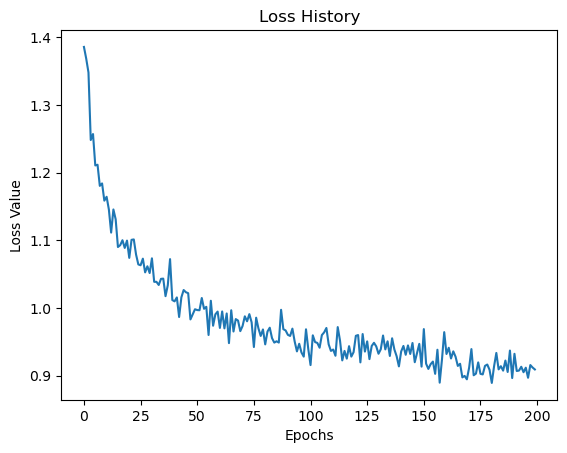

In [20]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_three_blocks_sgd.pdf", bbox_inches="tight")
plt.show()

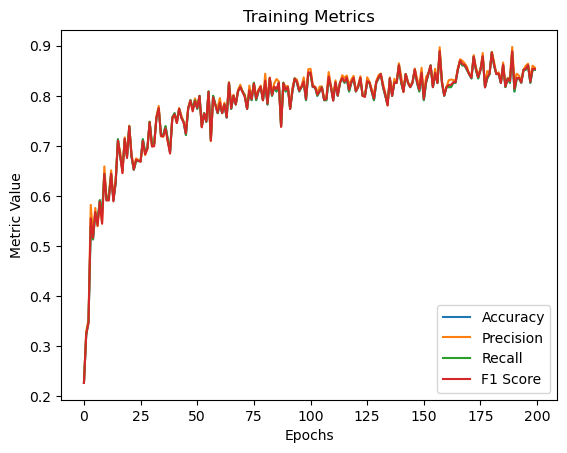

In [21]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_three_blocks_sgd.pdf", bbox_inches="tight")
plt.show()

In [22]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.7804347826086956
Mean Training Precision: 0.7848268249639587
Mean Training Recall: 0.7804347826086956
Mean Training F1 Score: 0.7807982262358613


In [23]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [24]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

/home/anirudhprabhakaran/miniconda3/envs/mp/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4572134017944336
Testing Accuracy: 0.27586206896551724
Testing Precision: 0.5217296113847838
Testing Recall: 0.27586206896551724
Testing F1 Score: 0.3422526253742224


## Adam

In [26]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv1d(128, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=3328, out_features=4, bias=True)
  (softmax): Softmax(dim=1)


In [27]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Sequential: 1-2                        [8, 128, 159]             --
│    └─Conv1d: 2-5                       [8, 128, 477]             24,704
│    └─MaxPool1d: 2-6                    [8, 128, 159]             --
│    └─Dropout: 2-7                      [8, 128, 159]             --
│    └─BatchNorm1d: 2-8                  [8, 128, 159]             256
├─Sequential: 1-3                        [8, 64, 52]               --
│    └─Conv1d: 2-9                       [8, 64, 157]              24,640
│   

In [28]:
tb_board = RUNS_PATH + "1d_cnn_three_blocks_adam"
writer = SummaryWriter(tb_board)

In [29]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3768651723861693 - Accuracy: 0.30434782608695654 - Precision: 0.3541016573053186 - Recall: 0.30434782608695654 - F1: 0.3171480152985669
Epoch: 2 - Loss: 1.287433648109436 - Accuracy: 0.40869565217391307 - Precision: 0.42140223906528257 - Recall: 0.40869565217391307 - F1: 0.4136453954354372
Epoch: 3 - Loss: 1.2033356865247091 - Accuracy: 0.5652173913043478 - Precision: 0.5568304159608507 - Recall: 0.5652173913043478 - F1: 0.5588385177330034
Epoch: 4 - Loss: 1.1675777832667034 - Accuracy: 0.5565217391304348 - Precision: 0.5429233204563536 - Recall: 0.5565217391304348 - F1: 0.5476593792218607
Epoch: 5 - Loss: 1.126976748307546 - Accuracy: 0.6086956521739131 - Precision: 0.616892911010558 - Recall: 0.6086956521739131 - F1: 0.6026671538180489
Epoch: 6 - Loss: 1.1478764176368714 - Accuracy: 0.6173913043478261 - Precision: 0.6199497512031976 - Recall: 0.6173913043478261 - F1: 0.6179934611818669
Epoch: 7 - Loss: 1.1475739359855652 - Accuracy: 0.5739130434782609 - Precision: 

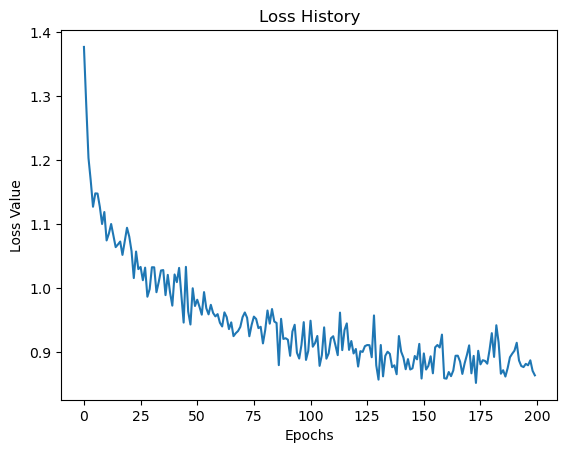

In [32]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_three_blocks_adam.pdf", bbox_inches="tight")
plt.show()

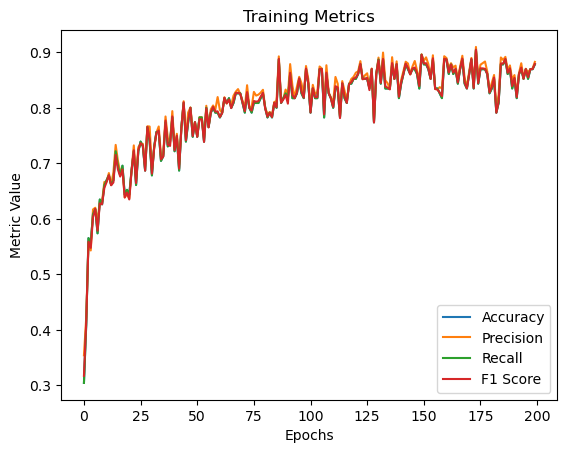

In [33]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_three_blocks_adam.pdf", bbox_inches="tight")
plt.show()

In [34]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.799608695652174
Mean Training Precision: 0.8060640728034798
Mean Training Recall: 0.799608695652174
Mean Training F1 Score: 0.8001553877040951


In [35]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [36]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [37]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4160373210906982
Testing Accuracy: 0.3103448275862069
Testing Precision: 0.4395183360700602
Testing Recall: 0.3103448275862069
Testing F1 Score: 0.3604355716878403
